In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import warnings
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
train['time_entry'] = pd.to_datetime(train['time_entry'], format='%H:%M:%S')
train['time_exit'] = pd.to_datetime(train['time_exit'], format='%H:%M:%S')


In [3]:
train.sort_values(by=['hash', 'time_entry', 'time_exit']).head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,1900-01-01 07:04:31,1900-01-01 07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,1900-01-01 07:20:34,1900-01-01 07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,1900-01-01 07:53:32,1900-01-01 08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,1900-01-01 08:17:50,1900-01-01 08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,1900-01-01 14:38:09,1900-01-01 14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0     814262 non-null  int64         
 1   hash           814262 non-null  object        
 2   trajectory_id  814262 non-null  object        
 3   time_entry     814262 non-null  datetime64[ns]
 4   time_exit      814262 non-null  datetime64[ns]
 5   vmax           256769 non-null  float64       
 6   vmin           256769 non-null  float64       
 7   vmean          270778 non-null  float64       
 8   x_entry        814262 non-null  float64       
 9   y_entry        814262 non-null  float64       
 10  x_exit         814262 non-null  float64       
 11  y_exit         814262 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 74.5+ MB


In [24]:
(train.time_entry - train.time_exit).dt.total_seconds().value_counts()

 0.0        433077
-301.0        3133
-300.0        2656
-600.0        1500
-302.0        1430
             ...  
-10232.0         1
-3534.0          1
-5180.0          1
-5152.0          1
-4006.0          1
Length: 5398, dtype: int64

In [62]:
test.sort_values(by=['hash', 'time_entry', 'time_exit']).head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,11:43:17,11:50:17,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,-1.914508e+07
1,1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,12:21:37,12:21:37,0.0,0.0,0.0,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07
2,2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,12:34:27,13:14:11,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,-1.911092e+07
3,3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,13:25:33,13:43:13,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,-1.914465e+07
4,4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,15:03:32,15:10:32,NaN,NaN,NaN,3.773118e+06,-1.914490e+07,NaN,NaN


# EDA

In [136]:
# counting devices with only 1 trajectory

count = test.hash.value_counts()
device_1 = count.loc[count.values == 1].index.tolist()

test[test.hash.isin(device_1)].shape[0]

307

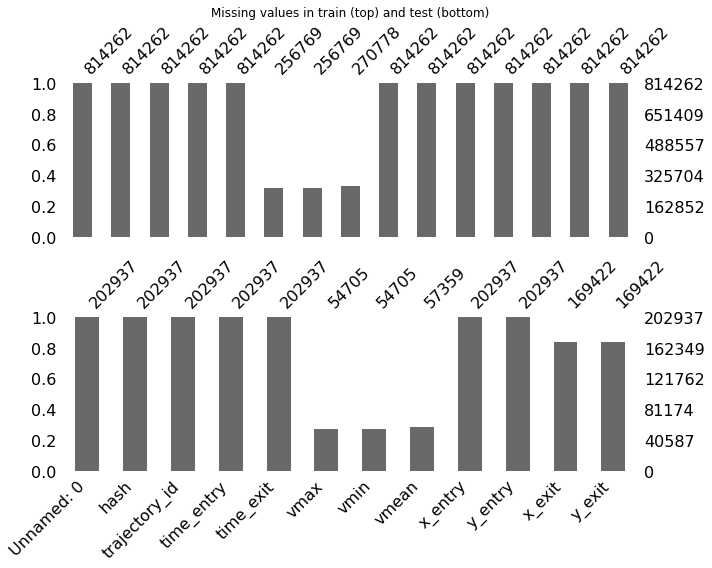

In [341]:
size = (10, 8)
plt.subplot(211)
plt.title('Missing values in train (top) and test (bottom)')
msno.bar(train, figsize=size)
plt.subplot(212)
msno.bar(test, figsize=size)
plt.tight_layout()

In [321]:
train.hash.nunique()

134063

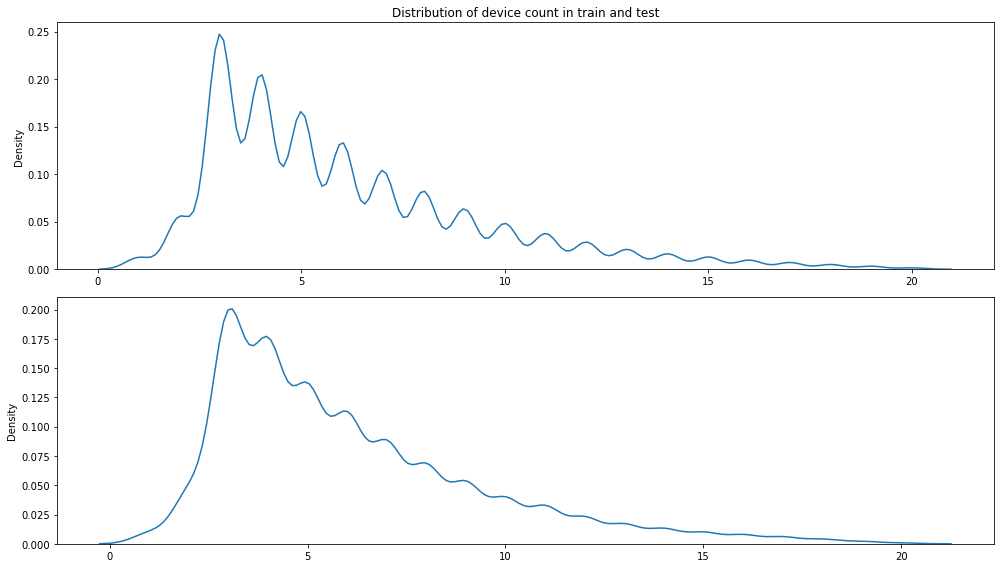

In [333]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title('Distribution of device count in train and test')
sns.kdeplot(train.hash.value_counts().values)
plt.subplot(212)
sns.kdeplot(test.hash.value_counts().values)
plt.tight_layout()

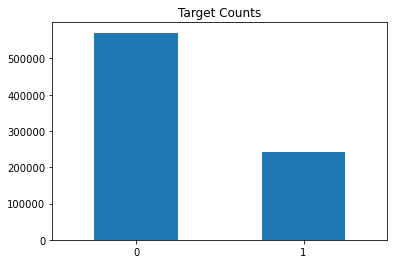

In [334]:
mask = ((-19268905.6133 <= train.y_exit) & (train.y_exit <= -19208905.6133) & (3750901.5068 <= train.x_exit) & (train.x_exit <= 3770901.5068))
train['target'] = np.where(mask, 1, 0)

train.target.value_counts().plot(kind='bar', rot=0, title='Target Counts')

In [323]:
train['delta_y'] = train.y_exit - train.y_entry
train['delta_x'] = train.x_exit - train.x_entry

std_delta = train.sort_values(by=['hash', 'time_entry', 'time_exit']).groupby('hash').agg({'delta_y': 'std', 'delta_x': 'std'})

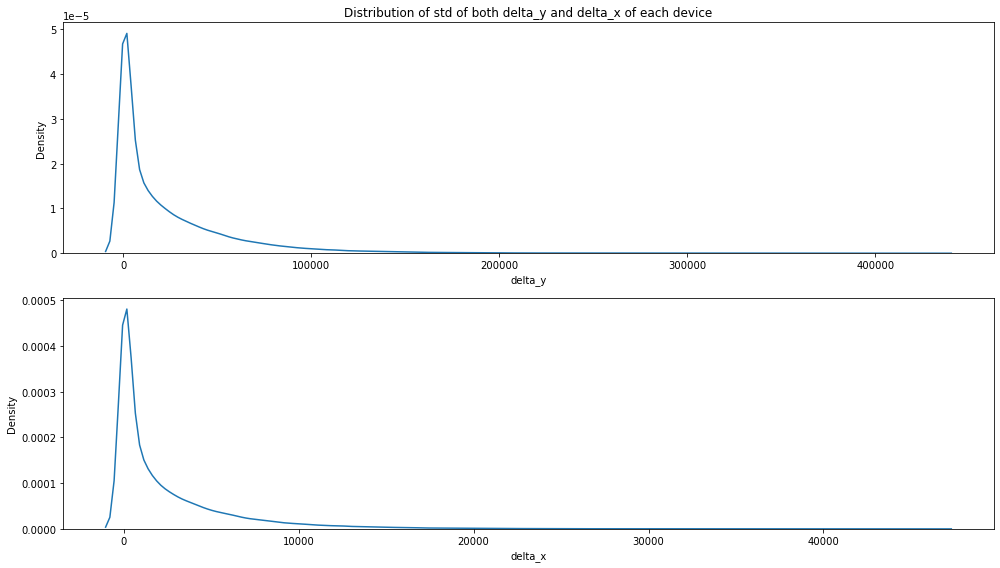

In [331]:
plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title('Distribution of std of both delta_y and delta_x of each device')
sns.kdeplot(std_delta.delta_y)
plt.subplot(212)
sns.kdeplot(std_delta.delta_x)
plt.tight_layout()

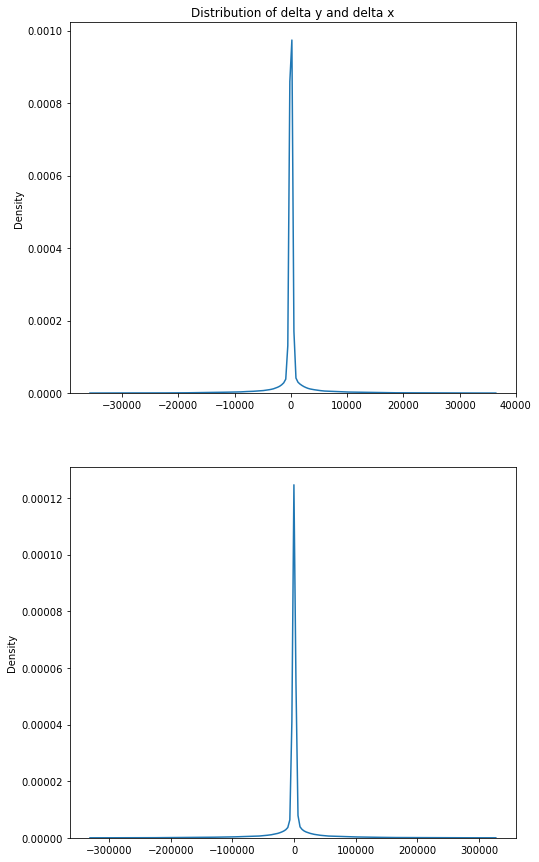

In [342]:
plt.figure(figsize=(8, 15))
plt.subplot(211)
plt.title('Distribution of delta y and delta x')
sns.kdeplot(train_.x_exit - train_.x_entry)
plt.subplot(212)
sns.kdeplot(train_.y_exit - train_.y_entry)

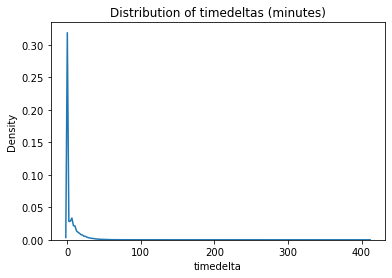

In [347]:
train['timedelta'] = (train.time_exit - train.time_entry).dt.total_seconds() / 60

plt.title('Distribution of timedeltas (minutes)')
sns.kdeplot(train['timedelta'])

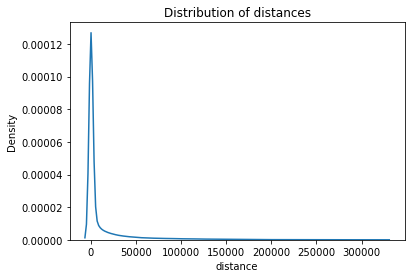

In [349]:
train['distance'] = np.sqrt((train.x_exit - train.x_entry)**2 + (train.y_exit - train.y_entry)**2)

plt.title('Distribution of distances')
sns.kdeplot(train['distance'])

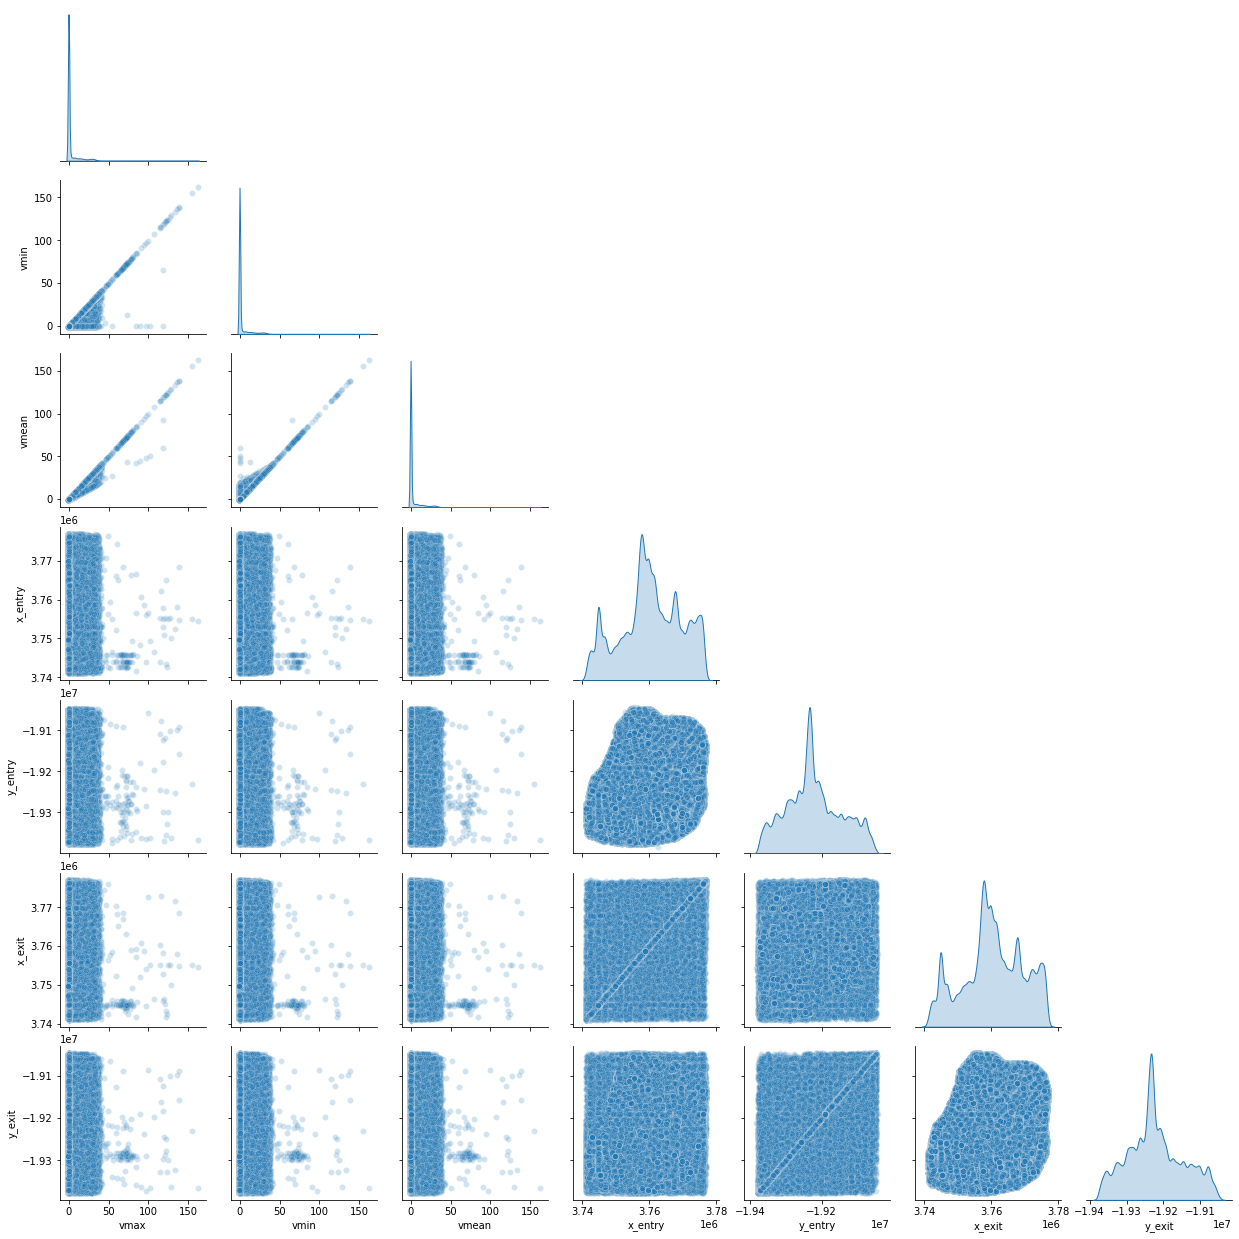

In [21]:
sns.pairplot(train[train.columns[3:]], corner=True, diag_kind='kde', plot_kws={'alpha': 0.2})

# Preprocessing & Feature Engineering / Creating Pipeline

In [4]:
def label_encode(df):
    cat_cols = [i for i in df.columns if df[i].dtypes == 'object']
    for i in cat_cols:
        df[i], indexer = pd.factorize(df[i])
        df[i].replace(-1, np.nan, inplace=True)
    return df, cat_cols

def pipeline(include_velocities=False, 
             include_distance=True,
             include_whole_distance=True,
             include_time_features=True,
             include_timedelta=True,
             include_zero_time_diff=True,
             include_nth_trajectory=True,
             include_whole_timedelta=True,
             label_encode_hash=False):
    
    train = pd.read_csv('data_train.csv')
    test = pd.read_csv('data_test.csv')
    
    df = train.append(test)
    
    
    df['time_entry'] = pd.to_datetime(df['time_entry'], format='%H:%M:%S')
    df['time_exit'] = pd.to_datetime(df['time_exit'], format='%H:%M:%S')
    
    if not include_velocities:
        df.drop(columns=['vmax', 'vmin', 'vmean'], inplace=True)
    
    # simple features
    if include_timedelta:
        df['timedelta'] = (df.time_entry - df.time_exit).dt.total_seconds()
        
    if include_zero_time_diff:
        df['0_timedelta'] = np.where((df.time_entry - df.time_exit).dt.total_seconds() == 0, 1, 0)
        
    if include_time_features:
        df['h_entry'] = df['time_entry'].dt.hour
        df['m_entry'] = df['time_entry'].dt.minute
        df['s_entry'] = df['time_entry'].dt.second
        df['h_exit'] = df['time_exit'].dt.hour
        df['m_exit'] = df['time_exit'].dt.minute
        df['s_exit'] = df['time_exit'].dt.second
    
    # calculating distance using pythagorean theorem
    if include_distance:
        df['distance'] = np.sqrt((df.x_exit - df.x_entry)**2 + (df.y_exit - df.y_entry)**2)
        
    # calculating whole distance before 15:00
    if include_whole_distance:
        first_trajectory = df.sort_values(by=['hash', 'time_entry', 'time_exit']).groupby('hash').nth(1).reset_index()[['hash', 'x_entry', 'y_entry']]
        second_last_trajectory = df.sort_values(by=['hash', 'time_entry', 'time_exit']).groupby('hash').nth(-2).reset_index()[['hash', 'x_exit', 'y_exit']]

        whole_trajectory = first_trajectory.merge(second_last_trajectory, how='left', on='hash')
        whole_trajectory['whole_distance'] = np.sqrt((whole_trajectory.x_exit - whole_trajectory.x_entry)**2 + (whole_trajectory.y_exit - whole_trajectory.y_entry)**2)
    
        df = df.merge(whole_trajectory[['hash', 'whole_distance']], on='hash', how='left')
    
    # calculating whole timedelta before 15:00
    if include_whole_timedelta:
        first_trajectory = df.sort_values(by=['hash', 'time_entry', 'time_exit']).groupby('hash').nth(1).reset_index()[['hash', 'time_entry']]
        second_last_trajectory = df.sort_values(by=['hash', 'time_entry', 'time_exit']).groupby('hash').nth(-2).reset_index()[['hash', 'time_exit']]

        whole_trajectory = first_trajectory.merge(second_last_trajectory, how='left', on='hash')
        whole_trajectory['whole_timedelta'] = (whole_trajectory.time_exit - whole_trajectory.time_entry).dt.total_seconds()
        df = df.merge(whole_trajectory[['hash', 'whole_timedelta']], on='hash', how='left')
    
    if include_nth_trajectory:
        df['nth_trajectory'] = df['trajectory_id'].apply(lambda x: int(x[-1]))
    
    df.set_index('trajectory_id', inplace=True)
    
    if label_encode_hash:
        df, cat_cols = label_encode(df)
    else:
        df.drop(columns=['hash'], inplace=True)
    
    df.drop(columns=['Unnamed: 0', 'time_entry', 'time_exit'], inplace=True)
    
    
    train = df[(df.y_exit.notna()) & (df.x_exit.notna())]
    test = df[(df.y_exit.isna()) & (df.x_exit.isna())]
    
    mask = ((-19268905.6133 <= train.y_exit) & (train.y_exit <= -19208905.6133) & (3750901.5068 <= train.x_exit) & (train.x_exit <= 3770901.5068))
    train['target'] = np.where(mask, 1, 0)
    
    return train, test

In [9]:
TRAIN_PARAMS = {
    'include_velocities': False,
    'include_distance': False,
    'include_time_features': True,
    'include_timedelta': True,
    'include_zero_time_diff': True,
    'include_whole_distance': True,
    'label_encode_hash': True,
    'include_nth_trajectory': True,
    'include_whole_timedelta': True,
}


train_, test_ = pipeline(**TRAIN_PARAMS)

test_ = test_.drop(columns=['x_exit', 'y_exit'])

X = train_.drop(columns=['target', 'x_exit', 'y_exit'])
y = train_[['x_exit', 'y_exit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)

y1_train = y_train['x_exit']
y2_train = y_train['y_exit']
y1_test = y_test['x_exit']
y2_test = y_test['y_exit']

# Shortlisting Models

In [14]:
xgb_params_ = dict(learning_rate=0.05,
                  n_estimators=10000,
                  max_depth=10,
                 tree_method='gpu_hist')

xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
xgb_reg2 = xgb.XGBRegressor(**xgb_params_)

xgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
xgb_reg2.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)

[0]	validation_0-rmse:3572386.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:3007.00024
Stopping. Best iteration:
[293]	validation_0-rmse:3004.00122

[0]	validation_0-rmse:18260890.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:27332.62695
Stopping. Best iteration:
[289]	validation_0-rmse:27277.00977



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [288]:
cb_params = dict(loss_function="RMSE",
                 eval_metric="RMSE",
                 task_type="GPU",
                 learning_rate=0.003,
                 iterations=180000,
                 max_depth=10)

cb_reg1 = cb.CatBoostRegressor(**cb_params)
cb_reg2 = cb.CatBoostRegressor(**cb_params)

cb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], early_stopping_rounds=1000, verbose=1000)
cb_reg2.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], early_stopping_rounds=1000, verbose=1000)

0:	learn: 8874.0096226	test: 8864.4051428	best: 8864.4051428 (0)	total: 36.8ms	remaining: 1h 50m 28s
1000:	learn: 3178.0995613	test: 3182.3766998	best: 3182.3766998 (1000)	total: 31.8s	remaining: 1h 34m 47s
2000:	learn: 3090.0742138	test: 3117.8776356	best: 3117.8776356 (2000)	total: 1m 4s	remaining: 1h 35m 21s
3000:	learn: 3053.9554404	test: 3107.5140020	best: 3107.5140020 (3000)	total: 1m 37s	remaining: 1h 35m 49s
4000:	learn: 3022.7189403	test: 3101.7487553	best: 3101.7487553 (4000)	total: 2m 10s	remaining: 1h 35m 58s
5000:	learn: 2994.7368639	test: 3099.0053691	best: 3098.9989848 (4994)	total: 2m 44s	remaining: 1h 36m 1s
6000:	learn: 2970.1863655	test: 3097.6063689	best: 3097.6051958 (5999)	total: 3m 18s	remaining: 1h 35m 48s
7000:	learn: 2947.9303042	test: 3097.1315949	best: 3096.9572842 (6690)	total: 3m 51s	remaining: 1h 35m 16s
8000:	learn: 2926.6895778	test: 3096.4357277	best: 3096.4224269 (7984)	total: 4m 24s	remaining: 1h 34m 53s
9000:	learn: 2906.4960264	test: 3096.1670918	b

0:	learn: 74972.5992143	test: 74824.5087439	best: 74824.5087439 (0)	total: 33.7ms	remaining: 1h 41m 1s
1000:	learn: 28566.4215167	test: 28552.6857301	best: 28552.6857301 (1000)	total: 31.9s	remaining: 1h 35m 11s
2000:	learn: 27882.0691512	test: 28089.8271132	best: 28089.8271132 (2000)	total: 1m 3s	remaining: 1h 34m 32s
3000:	learn: 27615.2437133	test: 28063.3030630	best: 28063.0728536 (2978)	total: 1m 36s	remaining: 1h 34m 34s
4000:	learn: 27400.8672602	test: 28059.1479539	best: 28057.9736925 (3805)	total: 2m 8s	remaining: 1h 34m 8s
bestTest = 28057.97369
bestIteration = 3805
Shrink model to first 3806 iterations.


In [286]:
lgb_params_ = {
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'n_estimators': 10000,
                    'learning_rate': 0.005,
                    'metric': 'rmse',
                    'max_depth': 10
                }


lgb_reg1 = lgb.LGBMRegressor(**lgb_params_)
lgb_reg2 = lgb.LGBMRegressor(**lgb_params_)

lgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
lgb_reg1.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)

Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3195.85
[1000]	valid_0's rmse: 3073.65
[1500]	valid_0's rmse: 3053.8
[2000]	valid_0's rmse: 3046.98
[2500]	valid_0's rmse: 3042.12
[3000]	valid_0's rmse: 3038.69
[3500]	valid_0's rmse: 3035.67
[4000]	valid_0's rmse: 3033.19
[4500]	valid_0's rmse: 3031.49
[5000]	valid_0's rmse: 3029.19
[5500]	valid_0's rmse: 3027.55
[6000]	valid_0's rmse: 3026.34
[6500]	valid_0's rmse: 3024.84
[7000]	valid_0's rmse: 3023.94
[7500]	valid_0's rmse: 3022.96
[8000]	valid_0's rmse: 3022.43
[8500]	valid_0's rmse: 3021.45
[9000]	valid_0's rmse: 3020.64
[9500]	valid_0's rmse: 3020.17
[10000]	valid_0's rmse: 3019.42
Did not meet early stopping. Best iteration is:
[9965]	valid_0's rmse: 3019.41
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 28741.2
[1000]	valid_0's rmse: 27759.9
[1500]	valid_0's rmse: 27646.9
[2000]	valid_0's rmse: 27601.8
[2500]	valid_0's rmse: 27573.7
[3000]	valid_0's rmse: 2

LGBMRegressor(learning_rate=0.005, max_depth=10, metric='rmse',
              n_estimators=10000, objective='regression')

**Conclusion**:

With standard hyperparameters, XGBoost fits the model best with LightGBM trailing closely behind. The LGBM regressors didn't seem to have converge yet, but it's already clear that XGBoost is the better model of the two.

# Feature Importance

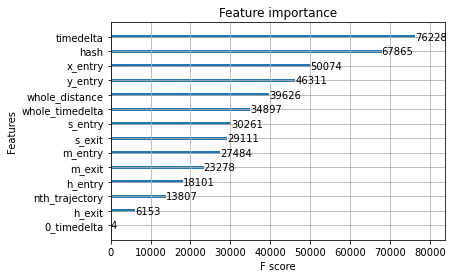

In [15]:
xgb.plot_importance(xgb_reg1)

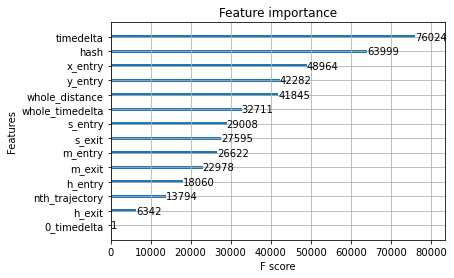

In [16]:
xgb.plot_importance(xgb_reg2)

Simulating real test set where we predict the exit point of the last trajectory..

In [30]:
TRAIN_PARAMS = {
    'include_velocities': False,
    'include_distance': False,
    'include_time_features': True,
    'include_timedelta': True,
    'include_zero_time_diff': True,
    'include_whole_distance': True,
    'label_encode_hash': True,
    'include_nth_trajectory': True,
    'include_whole_timedelta': True,
}


train_, test_ = pipeline(**TRAIN_PARAMS)

test_ = test_.drop(columns=['x_exit', 'y_exit'])



test__ = train_[train_.h_entry >= 15]
train__ = train_[train_.h_entry <= 15]

X_train = train__.drop(columns=['target', 'x_exit', 'y_exit'])
y_train = train__[['x_exit', 'y_exit']]
X_test = test__.drop(columns=['target', 'x_exit', 'y_exit'])
y_test = test__[['x_exit', 'y_exit']]

y1_train = y_train['x_exit']
y2_train = y_train['y_exit']
y1_test = y_test['x_exit']
y2_test = y_test['y_exit']

xgb_params_ = dict(learning_rate=0.05,
                  n_estimators=10000,
                  max_depth=10,
                 tree_method='gpu_hist')

xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
xgb_reg2 = xgb.XGBRegressor(**xgb_params_)

xgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
xgb_reg2.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)

[0]	validation_0-rmse:3572419.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:2216.80151
[1000]	validation_0-rmse:1790.89673
[1500]	validation_0-rmse:1474.48535
[2000]	validation_0-rmse:1233.25989
[2500]	validation_0-rmse:1050.66821
[3000]	validation_0-rmse:902.26434
[3500]	validation_0-rmse:782.42694
[4000]	validation_0-rmse:666.18603
[4500]	validation_0-rmse:576.64508
[5000]	validation_0-rmse:497.32864
[5500]	validation_0-rmse:432.04861
[6000]	validation_0-rmse:374.95727
[6500]	validation_0-rmse:325.57550
[7000]	validation_0-rmse:285.70975
[7500]	validation_0-rmse:250.31964
[8000]	validation_0-rmse:215.57268
[8500]	validation_0-rmse:190.89540
[9000]	validation_0-rmse:168.61493
[9500]	validation_0-rmse:148.05620
[9999]	validation_0-rmse:130.62637
[0]	validation_0-rmse:18260738.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:22569.83594
[1000]	validation_0-rmse:18401.14648
[1500]	validation_

KeyboardInterrupt: 

# Hyperparameter Optimization

In [45]:
TRAIN_PARAMS = {
    'include_velocities': False,
    'include_distance': False,
    'include_time_features': True,
    'include_timedelta': True,
    'include_zero_time_diff': True,
    'include_whole_distance': True,
    'label_encode_hash': True,
    'include_nth_trajectory': True,
    'include_whole_timedelta': True,
}


train_, test_ = pipeline(**TRAIN_PARAMS)

test_ = test_.drop(columns=['x_exit', 'y_exit'])

X = train_.drop(columns=['target', 'x_exit', 'y_exit'])
y1 = train_['x_exit']
y2 = train_['y_exit']

In [46]:
from sklearn.model_selection import KFold
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

folds = KFold(n_splits=3, random_state=22)

def obj(params, folds=folds):
    
    print('============================================ Beginning Trial ============================================')
    params = {
     'learning_rate': params['learning_rate'],
     'colsample_bytree': params['colsample_bytree'],
     'n_estimators': 15000,
     'max_depth': int(params['max_depth']),
     'tree_method': 'gpu_hist'
    }
    
    print(f'Parameters:\n {params}\n\n')
    scores = []

    for fold, (train_index, test_index) in enumerate(folds.split(X, y1)):
        print(f'====================== Fitting fold {fold+1} ======================')
        X_train, y1_train = X.iloc[train_index], y1.iloc[train_index]
        X_test, y1_test = X.iloc[test_index], y1.iloc[test_index]
        xgb_reg1 = xgb.XGBRegressor(**params)
        xgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
        fold_score = xgb_reg1.best_score
        scores.append(fold_score)
    score = np.mean(scores)
    print(f'========================================= Trial score: {round(score, 6)} =========================================\n\n')
    return score

In [47]:
search = {
        'max_depth': hp.uniform("max_depth", 5, 10),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'learning_rate': hp.loguniform('learning_rate', -4.5, -3)
       }
trials = Trials()

rstate = np.random.RandomState(22)

best = fmin(fn=obj, space=search, algo=tpe.suggest, max_evals=10, rstate=rstate, trials=trials)

============================================ Beginning Trial ============================================              
Parameters:                                                                                                            
 {'learning_rate': 0.04613115964575704, 'colsample_bytree': 0.6000000000000001, 'n_estimators': 15000, 'max_depth': 5, 'tree_method': 'gpu_hist'}


====================== Fitting fold 1 ======================                                                           
[0]	validation_0-rmse:3586923.25000                                                                                    

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3074.54297                                                                                     

[1000]	validation_0-rmse:3061.13281                                                                                    

[1500]	v

[0]	validation_0-rmse:3701532.50000                                                                                    

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3402.91626                                                                                     

[1000]	validation_0-rmse:3078.39941                                                                                    

[1500]	validation_0-rmse:3066.30615                                                                                    

[2000]	validation_0-rmse:3057.27075                                                                                    

[2500]	validation_0-rmse:3054.30811                                                                                    

[3000]	validation_0-rmse:3052.04053                                                                                    

[3500]	validation_0-rmse:3050.83

========================================= Trial score: 3033.024984 =========================================           


============================================ Beginning Trial ============================================              
Parameters:                                                                                                            
 {'learning_rate': 0.02072216622684935, 'colsample_bytree': 0.5, 'n_estimators': 15000, 'max_depth': 9, 'tree_method': 'gpu_hist'}


====================== Fitting fold 1 ======================                                                           
[0]	validation_0-rmse:3682471.75000                                                                                    

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3067.76245                                                                                     

[1000]	validation_0-rm

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3046.91211                                                                                     

Stopping. Best iteration:                                                                                              
[365]	validation_0-rmse:3044.67895


====================== Fitting fold 2 ======================                                                           
[0]	validation_0-rmse:3643130.75000                                                                                    

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3049.75708                                                                                     

[1000]	validation_0-rmse:3041.26611                                                                                   

Will train until validation_0-rmse hasn't improved in 500 rounds.                                                      

[500]	validation_0-rmse:3109.99097                                                                                     

[1000]	validation_0-rmse:3086.99316                                                                                    

[1500]	validation_0-rmse:3074.62817                                                                                    

[2000]	validation_0-rmse:3067.84375                                                                                    

[2500]	validation_0-rmse:3061.82519                                                                                    

[3000]	validation_0-rmse:3059.32495                                                                                    

[3500]	validation_0-rmse:3058.35522                                                                                    

[4000]	validation_0-rmse:3057.87

In [48]:
best

{'colsample_bytree': 0.6000000000000001,
 'depth': 9.278944793502184,
 'learning_rate': 0.012803407783213067}

In [64]:
best_params = {i:[best[i]] for i in best.keys()}

results = [[i['tid'] + 1,
           i['result']['loss'], 
           i['misc']['vals']['depth'][0],
           i['misc']['vals']['colsample_bytree'][0],
           i['misc']['vals']['learning_rate'][0]] for i in trials.trials]
results_df = pd.DataFrame(results, columns=['Trial ID', 'Loss ↓', 'depth', 'colsample_bytree','learning_rate'])
results_df = results_df.append(pd.DataFrame(best_params))
results_df.loc[results_df['Trial ID'].isna(), 'Trial ID'] = 'best'
results_df.sort_values('Loss ↓')

,Trial ID,Loss ↓,depth,colsample_bytree,learning_rate
3,4,3023.142334,9.278945,0.6,0.012803
5,6,3031.345541,9.643890,0.5,0.020722
4,5,3033.024984,8.114320,0.6,0.042104
7,8,3038.689453,8.239330,0.9,0.031208
6,7,3044.005371,6.969121,0.7,0.012639
2,3,3044.365072,6.249466,0.8,0.015677
1,2,3046.472005,8.051854,1.0,0.019185
0,1,3052.415120,5.242225,0.6,0.046131
9,10,3053.661784,5.185732,0.8,0.022443
8,9,3054.768148,5.837773,0.8,0.012142


## Plugging in values from hyperopt..

In [59]:
# Testing first regression model

folds = KFold(n_splits=3, random_state=22)

# replacing lr, max_depth, and colsample_bytree by values suggested by hyperopt
xgb_params_ = dict(n_estimators=15000,
                  tree_method='gpu_hist',
                  learning_rate=0.012803,
                  max_depth=9,
                  colsample_bytree=0.6)

for fold, (train_index, test_index) in enumerate(folds.split(X, y1)):
        print(f'\n\n====================== Fitting fold {fold+1} ======================')
        X_train, y1_train = X.iloc[train_index], y1.iloc[train_index]
        X_test, y1_test = X.iloc[test_index], y1.iloc[test_index]
        xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
        xgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
        fold_score = xgb_reg1.best_score



====================== Fitting fold 1 ======================
[0]	validation_0-rmse:3712251.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:6715.22998
[1000]	validation_0-rmse:3038.08179
[1500]	validation_0-rmse:3034.50000
Stopping. Best iteration:
[1227]	validation_0-rmse:3033.58838



====================== Fitting fold 2 ======================
[0]	validation_0-rmse:3712341.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:6711.52490
[1000]	validation_0-rmse:3047.71729
[1500]	validation_0-rmse:3037.51489
[2000]	validation_0-rmse:3034.12598
[2500]	validation_0-rmse:3033.56299
[3000]	validation_0-rmse:3033.70459
Stopping. Best iteration:
[2627]	validation_0-rmse:3033.13672



====================== Fitting fold 3 ======================
[0]	validation_0-rmse:3712265.25000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:6718.72705
[1000]	validation_0-rm

In [68]:
# Testing second regression model

folds = KFold(n_splits=3, random_state=22)

# replacing lr, max_depth, and colsample_bytree by values suggested by hyperopt
xgb_params_ = dict(n_estimators=15000,
                  tree_method='gpu_hist',
                  learning_rate=0.012803,
                  max_depth=9,
                  colsample_bytree=0.6)

for fold, (train_index, test_index) in enumerate(folds.split(X, y2)):
        print(f'\n\n====================== Fitting fold {fold+1} ======================')
        X_train, y2_train = X.iloc[train_index], y2.iloc[train_index]
        X_test, y2_test = X.iloc[test_index], y2.iloc[test_index]
        xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
        xgb_reg1.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
        fold_score = xgb_reg1.best_score



====================== Fitting fold 1 ======================
[0]	validation_0-rmse:18976288.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:41716.65625
[1000]	validation_0-rmse:27711.91797
[1500]	validation_0-rmse:27709.46484
Stopping. Best iteration:
[1127]	validation_0-rmse:27700.24023



====================== Fitting fold 2 ======================
[0]	validation_0-rmse:18975534.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:41375.79688
[1000]	validation_0-rmse:27673.96484
[1500]	validation_0-rmse:27615.01758
[2000]	validation_0-rmse:27604.08984
[2500]	validation_0-rmse:27602.75195
[3000]	validation_0-rmse:27612.38086
Stopping. Best iteration:
[2627]	validation_0-rmse:27601.82812



====================== Fitting fold 3 ======================
[0]	validation_0-rmse:18975804.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:41377.57031
[1000]	

In [69]:
print('Average RMSE (of the first model) after hyperparameter opt: ', np.mean([3033.58838, 3033.13672, 2997.93286]))

Average RMSE (of the first model) after hyperparameter opt:  3021.5526533333336


In [66]:
results_df.loc[results_df['Loss ↓'].isna(), 'Loss ↓'] = 3021.5526533333336
results_df.sort_values('Loss ↓')

,Trial ID,Loss ↓,depth,colsample_bytree,learning_rate
0,best,3021.552653,9.278945,0.6,0.012803
3,4,3023.142334,9.278945,0.6,0.012803
5,6,3031.345541,9.643890,0.5,0.020722
4,5,3033.024984,8.114320,0.6,0.042104
7,8,3038.689453,8.239330,0.9,0.031208
6,7,3044.005371,6.969121,0.7,0.012639
2,3,3044.365072,6.249466,0.8,0.015677
1,2,3046.472005,8.051854,1.0,0.019185
0,1,3052.415120,5.242225,0.6,0.046131
9,10,3053.661784,5.185732,0.8,0.022443


# Evaluating Predictions

In [71]:
TRAIN_PARAMS = {
    'include_velocities': False,
    'include_distance': False,
    'include_time_features': True,
    'include_timedelta': True,
    'include_zero_time_diff': True,
    'include_whole_distance': True,
    'label_encode_hash': True,
    'include_nth_trajectory': True,
    'include_whole_timedelta': True,
}


train_, test_ = pipeline(**TRAIN_PARAMS)

test_ = test_.drop(columns=['x_exit', 'y_exit'])

X = train_.drop(columns=['target', 'x_exit', 'y_exit'])
y = train_[['x_exit', 'y_exit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)

y1_train = y_train['x_exit']
y2_train = y_train['y_exit']
y1_test = y_test['x_exit']
y2_test = y_test['y_exit']

xgb_params_ = dict(n_estimators=15000,
                  tree_method='gpu_hist',
                  learning_rate=0.012803,
                  max_depth=9,
                  colsample_bytree=0.6)

xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
xgb_reg2 = xgb.XGBRegressor(**xgb_params_)

xgb_reg1.fit(X_train, y1_train, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
xgb_reg2.fit(X_train, y2_train, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)

[0]	validation_0-rmse:3712261.25000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:6686.13672
[1000]	validation_0-rmse:3014.82446
[1500]	validation_0-rmse:3002.87549
[2000]	validation_0-rmse:3000.35913
[2500]	validation_0-rmse:2998.80200
[3000]	validation_0-rmse:2997.72119
[3500]	validation_0-rmse:2997.89404
Stopping. Best iteration:
[3070]	validation_0-rmse:2997.26367

[0]	validation_0-rmse:18975884.00000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:41229.31641
[1000]	validation_0-rmse:27363.04688
[1500]	validation_0-rmse:27293.86914
[2000]	validation_0-rmse:27277.04102
[2500]	validation_0-rmse:27272.43164
[3000]	validation_0-rmse:27273.02734
Stopping. Best iteration:
[2679]	validation_0-rmse:27269.99023



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.012803, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=15000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [72]:
y_pred_1 = xgb_reg1.predict(X_test)
y_pred_2 = xgb_reg2.predict(X_test)

In [104]:
y_pred = np.array([y_pred_1, y_pred_2])

In [116]:
pred_df = pd.DataFrame(zip(y_pred_1, y_pred_2), columns=['x_exit_pred', 'y_exit_pred'])

In [133]:
X_test_res = X_test.reset_index()
y1_test_res = y1_test.reset_index().drop('trajectory_id', axis=1)
y2_test_res = y2_test.reset_index().drop('trajectory_id', axis=1)

pred = pd.concat([X_test_res, y1_test_res, y2_test_res, pred_df], axis=1)

mask_real = ((-19268905.6133 <= pred.y_exit) & (pred.y_exit <= -19208905.6133) & (3750901.5068 <= pred.x_exit) & (pred.x_exit <= 3770901.5068))
mask_pred = ((-19268905.6133 <= pred.y_exit_pred) & (pred.y_exit_pred <= -19208905.6133) & (3750901.5068 <= pred.x_exit_pred) & (pred.x_exit_pred <= 3770901.5068))

pred['target_real'] = np.where(mask_real, 1, 0)
pred['target_pred'] = np.where(mask_pred, 1, 0)

## Confusion Matrix and F1 Score

In [135]:
from sklearn.metrics import confusion_matrix, f1_score

print('Confusion Matrix: \n', confusion_matrix(pred.target_real, pred.target_pred), '\n')
print('F1 Score: \n', f1_score(pred.target_real, pred.target_pred))

Confusion Matrix: 
 [[208404  18842]
 [  8272  89098]] 

F1 Score: 
 0.867936291461692


# Creating Submission

In [141]:
X = train_.drop(columns=['target', 'x_exit', 'y_exit'])
y1 = train_['x_exit']
y2 = train_['y_exit']

xgb_params_ = dict(n_estimators=15000,
                  tree_method='gpu_hist',
                  learning_rate=0.012803,
                  max_depth=9,
                  colsample_bytree=0.6)

xgb_reg1 = xgb.XGBRegressor(**xgb_params_)
xgb_reg2 = xgb.XGBRegressor(**xgb_params_)

xgb_reg1.fit(X, y1, eval_set=[(X_test, y1_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)
xgb_reg2.fit(X, y2, eval_set=[(X_test, y2_test)], eval_metric='rmse', early_stopping_rounds=500, verbose=500)

[0]	validation_0-rmse:3712261.50000
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:6663.83057
[1000]	validation_0-rmse:2813.47461
[1500]	validation_0-rmse:2687.23731
[2000]	validation_0-rmse:2598.95850
[2500]	validation_0-rmse:2514.06494
[3000]	validation_0-rmse:2432.90186
[3500]	validation_0-rmse:2359.08520
[4000]	validation_0-rmse:2289.66260
[4500]	validation_0-rmse:2220.66992
[5000]	validation_0-rmse:2157.33008
[5500]	validation_0-rmse:2096.18652
[6000]	validation_0-rmse:2044.74206
[6500]	validation_0-rmse:1990.55481
[7000]	validation_0-rmse:1938.31799
[7500]	validation_0-rmse:1888.74670
[8000]	validation_0-rmse:1843.08704
[8500]	validation_0-rmse:1798.31787
[9000]	validation_0-rmse:1754.68469
[9500]	validation_0-rmse:1714.14575
[10000]	validation_0-rmse:1675.16272
[10500]	validation_0-rmse:1636.62659
[11000]	validation_0-rmse:1596.74805
[11500]	validation_0-rmse:1560.06299
[12000]	validation_0-rmse:1525.70251
[12500]	validation_0-rmse:1490

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.012803, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=15000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [143]:
y_pred_1 = xgb_reg1.predict(test_)
y_pred_2 = xgb_reg2.predict(test_)

In [159]:
test_res = test_.reset_index()
pred = pd.DataFrame(zip(y_pred_1, y_pred_2), columns=['x_exit', 'y_exit'])
submission = pd.concat([test_res, pred], axis=1)
mask = ((-19268905.6133 <= pred.y_exit) & (pred.y_exit <= -19208905.6133) & (3750901.5068 <= pred.x_exit) & (pred.x_exit <= 3770901.5068))
submission['target'] = np.where(mask, 1, 0)
submission = submission[['trajectory_id', 'target']]
submission.columns = ['id', 'target']
submission.to_csv('submission.csv')
submission

,id,target
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0
...,...,...
33510,traj_ffe98f6e0adf12f9c7b51c4e9607a87a_15_13,0
33511,traj_fff607ecd3f8d3dcb65791e8b4c22a5f_3_25,1
33512,traj_fff813b56230c2f026f783f5b9f9ca90_19_0,0
33513,traj_fff9400843a88c3bfe52e7ce8bf97316_19_17,0
